In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import os.path as osp
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm
from torch import Tensor
import pickle
from datetime import datetime

from utils.dataset import SegmentationDataSet
from utils.printer import source_printer
from utils.printer import target_printer
from utils.model import UNet
from utils.model import YNet
from utils.model import Recons_net
from utils.utils import preprocessing
from utils.utils import IoU
from utils.utils import postprocessing
from utils.utils import dice_coeff
from utils.utils import multiclass_dice_coeff
from utils.utils import dice_loss
from utils.utils import smooth

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

Random Seed:  999


/tmp/ipykernel_9966/2216500334.py:48: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
date = str(datetime.now()).split(' ')[0]
heure = str(datetime.now()).split(' ')[1].split('.')[0]

# Root directory for dataset
##Refaire nos data folder et tout pour que ce soit 
#au format demandé par le dataloader



dataroot_source = "../data/IGBMC_LW4_diversifie/patches/"
train_list_source_path = "../data/IGBMC_LW4_diversifie/patches/train_5000_lw4.txt"


source_name = dataroot_source.split("/")[2].split("_")[1]

print(source_name)

#Some other roots
#Where to save plots, networks weights and final lists values
saving_folder = "../saves/U-Net"+dataroot_source.split('/')[3]+"_"+source_name+"_"+date+"_"+heure


os.mkdir(saving_folder) #We create this folder (only if it doesn't exists) to save weights of the training at some keys epoch
os.mkdir(saving_folder+"/loss-dice_listes")
os.mkdir(saving_folder+"/newtork_weigths")
os.mkdir(saving_folder+"/training_monitoring")

# Number of workers for dataloader
workers = 2

# Batch size during training (low batch_size if there are memory issues)
batch_size = 5

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size_source = 256
image_size_target = 256 
image_size_discriminator = 64

# Number of channels in the training images. For color images this is 3
nc = 2

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
learning_rate_unet=1e-5

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

#some unet variable
amp = False

LW4


In [5]:
print("number of gpus :", torch.cuda.device_count())

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("device ID", device)  #On regarde l'identifiant du GPU ou CPU sur lequel on travaille
print("nom du GPU", torch.cuda.get_device_name(device)) #On vérifie son "nom"

number of gpus : 1
device ID cuda:0
nom du GPU NVIDIA GeForce GTX 1080 Ti


In [7]:
log_file = open(saving_folder+"/log.txt", "w")

In [8]:
log_file.write("dataroot_source :"+dataroot_source+"\n")
log_file.write("train_list_source :"+train_list_source_path+"\n")
log_file.write("batch_size="+str(batch_size)+"\n")
log_file.write("learning_rate_unet="+str(learning_rate_unet)+"\n")
log_file.write("num_epoch="+str(num_epochs)+"\n")
log_file.write("nc="+str(nc)+"\n")

5

images source :  torch.Size([5, 3, 256, 256])
mask source : torch.Size([5, 3, 256, 256])


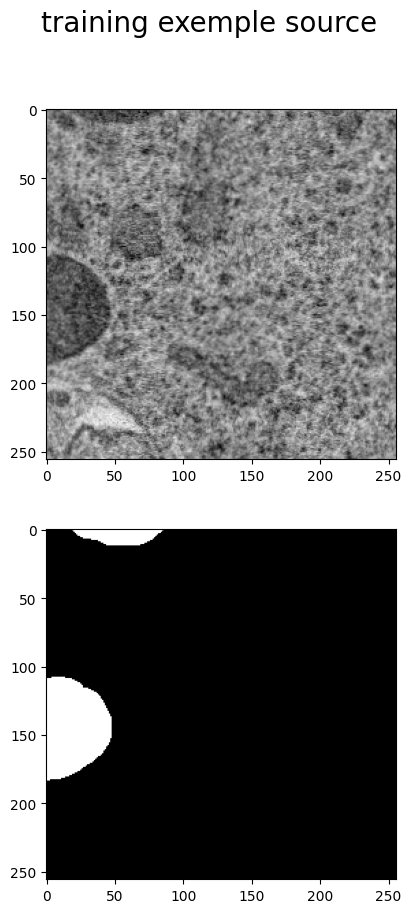

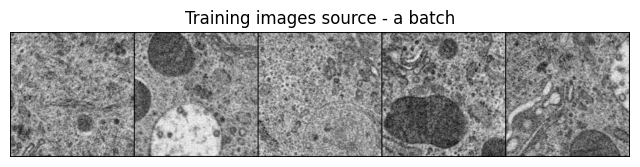

In [9]:
#Importation des images et masques de i3
dataset_source = SegmentationDataSet(root=dataroot_source,
                                     list_path=train_list_source_path)

# Dataloader pour i3
dataloader_source = torch.utils.data.DataLoader(dataset_source, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

#On affiche quelques exemple du batch pour vérifier qu'on a bien importé les données
source_printer(dataloader_source=dataloader_source, device=device)

In [120]:
state_dict = torch.load("/home/jonas/Documents/TER/saves/U-Netpatches_LW4_2023-01-16_17:57:11/newtork_weigths/UNet_75_epochs.pth")

unet = UNet(n_channels=3, n_classes=2, bilinear=False) #bilinear set by default to False here
unet.to(device=device)
unet.load_state_dict(state_dict)

#On revérifie qu'on tourne bien le réseau de neuronnes sur le GPU
print("We are running U-Net on :", torch.cuda.get_device_name(device))

if (device.type == 'cuda') and (ngpu > 1):
    unet = nn.DataParallel(unet, list(range(ngpu)))

We are running U-Net on : NVIDIA GeForce GTX 1080 Ti


In [121]:
#Loss, optimizers and friends for UNet

criterion_unet = nn.CrossEntropyLoss()

scheduler_params = dict(max_lr=learning_rate_unet, epochs=num_epochs, steps_per_epoch=len(dataloader_source))
optimizer_global = optim.AdamW(list(unet.parameters()))
scheduler_global = optim.lr_scheduler.OneCycleLR(optimizer_global, **scheduler_params)  # goal: maximize Dice score
grad_scaler_global = torch.cuda.amp.GradScaler(enabled=amp)  #Default parameter



In [122]:
log_file.write("dataroot_source :"+dataroot_source+"\n")
log_file.write("train_list_source :"+train_list_source_path+"\n")
log_file.write("batch_size="+str(batch_size)+"\n")
log_file.write("learning_rate_unet="+str(learning_rate_unet)+"\n")
log_file.write("num_epoch="+str(num_epochs)+"\n")
log_file.write("nc="+str(nc)+"\n")

5

## Ici on fait l'entrainement

In [ ]:
global_step = 0
n_train = len(dataset_source)
print(n_train)

print("Starting Training Loop...")

source_dice = []
intervalle = []

L_seg_list = []

L_s_list = []

compteur_plot = 0

for epoch in range(num_epochs):
    dice_score_target = []
    epoch_loss = 0
    cpt_it = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='img') as pbar:

        for batch_source in dataloader_source : 
            
            unet.train()
            
            cpt_it += 1
            
            images_source = batch_source ['image']
            true_masks_source = batch_source['mask']

            assert images_source.shape[1] == unet.n_channels


            images_source = images_source.to(device=device, dtype=torch.float32)
            true_masks_source = true_masks_source.to(device=device, dtype=torch.long)


            #Pass Data Trought Unet before optimizing everything

            with torch.cuda.amp.autocast(enabled=amp):
                masks_source_pred = unet(images_source)
                


            ############################
            # (2) Update Unet network: minimize Lseg(Xs)
            ###########################


            #D'abbord, on sort l'output du U-Net sur une image source (on a le mask)
            # En gros, ici on va sortir la Loss Lseg(Xs)
            with torch.cuda.amp.autocast(enabled=amp):
                L_seg = criterion_unet(masks_source_pred, true_masks_source[:,0,:,:]) \
                           + dice_loss(F.softmax(masks_source_pred, dim=1).float(),
                                       F.one_hot(true_masks_source[:,0,:,:], unet.n_classes).permute(0, 3, 1, 2).float(),
                                       multiclass=True)

            
            L_global = L_seg
            
            grad_scaler_global.scale(L_global).backward()
            grad_scaler_global.step(optimizer_global)
            grad_scaler_global.update()
            
            
            ###########################################################
            # Evaluation on the Training Set
            ###########################################################
            
            unet.eval()

            with torch.no_grad() :
                source_pred = unet(images_source)
                
                dice_source = dice_coeff(F.softmax(source_pred, dim=1).float(), 
                         F.one_hot(true_masks_source[:,0,:,:], unet.n_classes).permute(0, 3, 1, 2).float()).item()
                

                
                source_dice.append(dice_source)
                L_seg_list.append(L_global.item())
                intervalle.append(compteur_plot)
                

            
            compteur_plot += 1
            
            pbar.update(images_source.shape[0])
            global_step += 1
            epoch_loss += L_seg.item()

            
            pbar.set_postfix(**{'loss (batch)': L_seg.item()})
            #pbar.set_postfix(**{'dice target': dice_target})
            
        #print("whole epoch target dice mean :", sum(dice_score_target)/cpt_it)
        if (epoch%3==0) : #and epoch != 0 :
            torch.save(unet.state_dict(), saving_folder+"/newtork_weigths/UNet_"+str(epoch)+"_epochs.pth")
            #torch.save(ynet.state_dict(), saving_folder+"/newtork_weigths/recons_net_Cell_Seg_UDA_with_recons_4000-4000_"+str(epoch)+"_epochs.pth")
            
            source_smooth = smooth(source_dice, 0.99)
            
            L_seg_smooth = smooth(L_seg_list, 0.99)
            
            

            plt.figure(0)
            plt.clf()
            plt.plot(intervalle, source_smooth, 'b-', label='source')
            plt.title("dice score among training, smoothed")
            plt.xlabel("iterations")
            plt.ylabel("dice score (0 to 1)")
            plt.legend()
            plt.savefig(saving_folder+"/training_monitoring/dice_score_epoch_"+str(epoch)+".png")

            plt.show()
            
            plt.figure(1)
            plt.clf()
            plt.plot(intervalle, L_seg_smooth, 'r-', label='L_global')
            plt.xlabel("nb itérations")
            plt.ylabel("Loss Value")
            plt.title("Loss Monitoring among training")
            plt.legend()
            plt.savefig(saving_folder+"/training_monitoring/L_seg_"+str(epoch)+"_epoch.png")
            plt.show()